Model 1: Przewidywanie produktów dla dzieci

Wyniki cross-validacji:
Średnia dokładność: 0.84 (+/- 0.19)

Wagi cech w modelu:
         cecha      waga
1        cukry  0.500572
3     proteiny  0.031155
0      kalorie  0.020400
4      tluszcz -0.215487
2  weglowodany -0.329573
5      blonnik -1.481569

Model 2: Przewidywanie numeru półki

Raport klasyfikacji:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       1.00      0.43      0.60         7
           3       0.40      0.57      0.47         7

    accuracy                           0.44        16
   macro avg       0.47      0.33      0.36        16
weighted avg       0.61      0.44      0.47        16



C:\Users\iskow\PycharmProjects\MedTestyIS\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


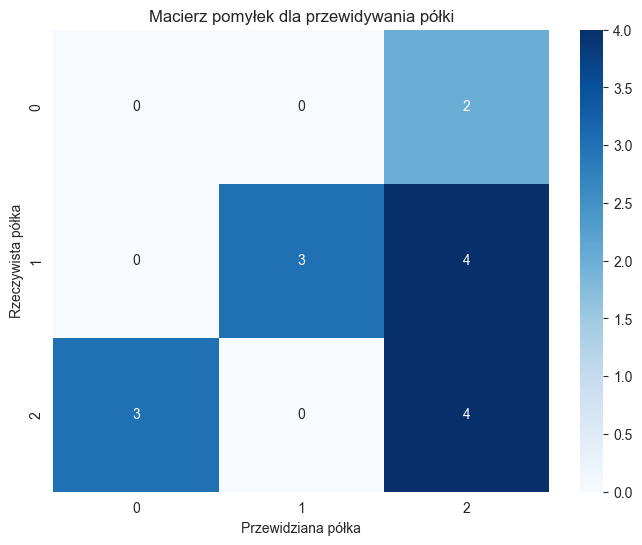


Model 3: Przewidywanie produktów premium (półka 1)

Wagi cech dla produktów premium:
         cecha      waga
2  weglowodany  0.493905
3     proteiny  0.405465
1        cukry  0.008780
0      kalorie -0.238057
5      blonnik -0.295285
4      tluszcz -0.651237

Przykład predykcji dla nowego produktu:
{'prawdopodobienstwo_dla_dzieci': np.float64(0.17075692663999686), 'przewidywana_polka': np.int64(3), 'prawdopodobienstwo_premium': np.float64(0.3007970600659376)}


C:\Users\iskow\PycharmProjects\MedTestyIS\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Wczytanie danych
df = pd.read_csv('Płatki-sniadaniowe-cereals.txt', sep='\t')

# Przygotowanie danych do modelowania
features = ['kalorie', 'cukry', 'weglowodany', 'proteiny', 'tluszcz', 'blonnik']
# features = ['kalorie', 'cukry']
X = df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Model 1: Przewidywanie czy produkt jest na środkowej półce (dla dzieci)
y_kids = (df['srodk_polka'] == 'T').astype(int)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_kids, test_size=0.2, random_state=42)

model_kids = LogisticRegression(random_state=42)
model_kids.fit(X_train, y_train)

# Ocena modelu
print("Model 1: Przewidywanie produktów dla dzieci")
print("\nWyniki cross-validacji:")
cv_scores = cross_val_score(model_kids, X_scaled, y_kids, cv=5)
print(f"Średnia dokładność: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})")

# Znaczenie cech
feature_importance = pd.DataFrame({
    'cecha': features,
    'waga': model_kids.coef_[0]
})
print("\nWagi cech w modelu:")
print(feature_importance.sort_values('waga', ascending=False))

# Model 2: Przewidywanie półki (multiclass)
y_shelf = df['Liczba_polek']
model_shelf = LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_shelf, test_size=0.2, random_state=42)
model_shelf.fit(X_train, y_train)

# Ocena modelu wieloklasowego
print("\nModel 2: Przewidywanie numeru półki")
print("\nRaport klasyfikacji:")
y_pred = model_shelf.predict(X_test)
print(classification_report(y_test, y_pred))

# Wizualizacja macierzy pomyłek
plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Macierz pomyłek dla przewidywania półki')
plt.xlabel('Przewidziana półka')
plt.ylabel('Rzeczywista półka')
plt.show()

# Model 3: Regresja logistyczna dla produktów premium (półka 1)
y_premium = df['polka_1'].astype(int)
model_premium = LogisticRegression(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_premium, test_size=0.2, random_state=42)
model_premium.fit(X_train, y_train)

print("\nModel 3: Przewidywanie produktów premium (półka 1)")
print("\nWagi cech dla produktów premium:")
premium_importance = pd.DataFrame({
    'cecha': features,
    'waga': model_premium.coef_[0]
})
print(premium_importance.sort_values('waga', ascending=False))


# Funkcja do predykcji dla nowego produktu
def predict_shelf_placement(nutrition_values):
    """
    Przewiduje półkę dla nowego produktu na podstawie wartości odżywczych

    Parametry:
    nutrition_values: słownik z wartościami odżywczymi
    """
    values = np.array([[
        nutrition_values['kalorie'],
        nutrition_values['cukry'],
        nutrition_values['weglowodany'],
        nutrition_values['proteiny'],
        nutrition_values['tluszcz'],
        nutrition_values['blonnik']
    ]])

    values_scaled = scaler.transform(values)

    kids_prob = model_kids.predict_proba(values_scaled)[0][1]
    shelf_pred = model_shelf.predict(values_scaled)[0]
    premium_prob = model_premium.predict_proba(values_scaled)[0][1]

    return {
        'prawdopodobienstwo_dla_dzieci': kids_prob,
        'przewidywana_polka': shelf_pred,
        'prawdopodobienstwo_premium': premium_prob
    }


# Przykład użycia
przyklad = {
    'kalorie': 100,
    'cukry': 7,
    'weglowodany': 15,
    'proteiny': 3,
    'tluszcz': 1,
    'blonnik': 2
}

print("\nPrzykład predykcji dla nowego produktu:")
print(predict_shelf_placement(przyklad))